2. Customer Engagement (Jun An)
○ What factors are most strongly correlated with customer engagement in
marketing campaigns?
○ Objective: Analyze historical marketing campaign data to identify the main
drivers of customer interaction and response.
○ Expected Outcome: Propose key metrics for tracking customer engagement
over time.


In [154]:
import pandas as pd 
import numpy as np 
import math
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats

In [155]:
os.chdir("..")
path = os.getcwd()
print(path)
data_folder_name = "Data DSA3101"
data_folder = os.path.join(path, data_folder_name)
os.chdir(data_folder)
# Load dataframes customer_engagement and campaigns and merge them on campaign_id
customers = pd.read_csv("customer_data_with_labels_only.csv")
customers = customers[customers['age'] >= 21]
customers = customers[customers['income'] >= 0]
customers = customers[customers['created_at'] < '2025-03-01']
#print(customers.head())
customer_engagement = pd.read_csv("customer_engagement.csv")
campaigns = pd.read_csv("campaigns.csv")
churn_data = pd.read_csv("churn.csv")

main_df = pd.merge(customer_engagement, customers, on="customer_id", how="inner")
print(main_df.head())
main_df = pd.merge(main_df, campaigns, on="campaign_id", how="inner")
#main_df = pd.merge(main_df, churn_data, on="customer_id", how="inner")
#main_df.to_excel("main_df.xlsx")

print(main_df.head(10))


/Users/junan/School/DSA3101/DSA3101-Project
   engagement_id  customer_id  campaign_id channel sent delivered opened  \
0              1         3110            1   Email  Yes       Yes     No   
1              2         2468            1   Email  Yes       Yes     No   
2              3         7168            1   Email  Yes       Yes     No   
3              4         9616            1   Email  Yes       Yes     No   
4              5         7365            1   Email  Yes       Yes     No   

  clicked      engagement_date engagement_time  ... income  \
0      No  2022-03-26 14:34:53        14:34:53  ...   2456   
1      No  2022-03-29 06:49:52        06:49:52  ...   3406   
2      No  2022-04-02 13:34:07        13:34:07  ...   3989   
3      No  2022-03-26 11:50:42        11:50:42  ...   5755   
4     Yes  2022-04-05 14:36:54        14:36:54  ...   3650   

                   created_at credit_card personal_loan mortgage  \
0  2023-05-02 14:05:10.998153           1             0   

In [156]:
# Ensure categorical values are converted to binary (Yes -> 1, No -> 0)
main_df['clicked'] = main_df['clicked'].apply(lambda x: 1 if x == 'Yes' else 0)
main_df['opened'] = main_df['opened'].apply(lambda x: 1 if x == 'Yes' else 0)
main_df['delivered'] = main_df['delivered'].apply(lambda x: 1 if x == 'Yes' else 0)
main_df['conversion_status'] = main_df['conversion_status'].apply(lambda x: 1 if x == 'Yes' else 0)
#main_df['churn'] = main_df['churn_status'].apply(lambda x: 1 if x == 'Yes' else 0)
# Encode Channel
le = LabelEncoder()
main_df['channel_encoded'] = le.fit_transform(main_df['channel'])

# Ensure date column is in datetime format
main_df['engagement_date'] = pd.to_datetime(main_df['engagement_date'])

# Extract hour and day of week
main_df['engagement_hour'] = main_df['engagement_date'].dt.hour  # 0-23
main_df['engagement_day'] = main_df['engagement_date'].dt.weekday  # Monday=0, Sunday=6  

#main_df.to_excel("main_df.xlsx")


# Group by campaign_id
campaign_metrics = main_df.groupby('campaign_id').agg(
    total_delivered=('delivered', 'sum'),
    total_clicked=('clicked', 'sum'),
    total_opened=('opened', 'sum'),
    total_converted=('conversion_status', 'sum'),
    channel = ('channel', 'first'),
    #total_churned=('churn', 'sum'),
    day = ('engagement_day', 'mean'),
    hour = ('engagement_hour', 'mean')
).reset_index()

# Compute engagement metrics
campaign_metrics['CTR%'] = (campaign_metrics['total_clicked'] / campaign_metrics['total_delivered']) * 100
campaign_metrics['Open Rate%'] = (campaign_metrics['total_opened'] / campaign_metrics['total_delivered']) * 100
campaign_metrics['Conversion Rate%'] = (campaign_metrics['total_converted'] / campaign_metrics['total_delivered']) * 100
#campaign_metrics['Churn Rate%'] = (campaign_metrics['total_churned'] / campaign_metrics['total_delivered']) * 100

# Fill NaN values with 0
campaign_metrics.fillna(0, inplace=True)

print(campaign_metrics)


    campaign_id  total_delivered  total_clicked  total_opened  \
0             1              430             32            95   
1             2              638             78           232   
2             3              880             48           211   
3             4              533             49           138   
4             5              711             62           223   
5             6              533             49           145   
6             7              453             33            81   
7             8              906             97           196   
8             9              759             61           137   
9            10              636             75           226   
10           11              204             21            47   
11           12              462             25           101   
12           13              648             56           203   
13           14              302             19            70   
14           15          

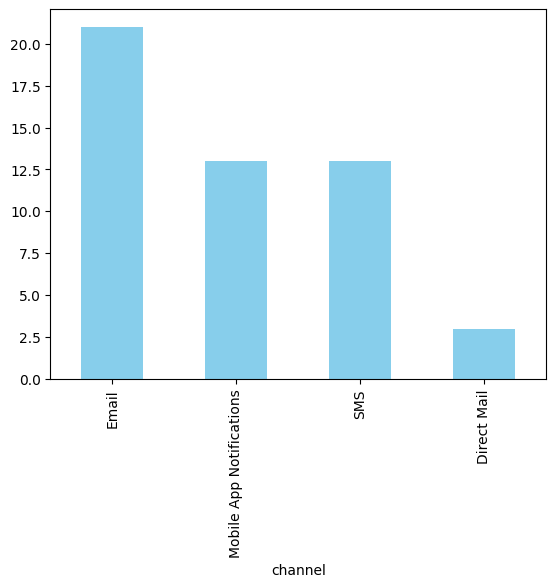

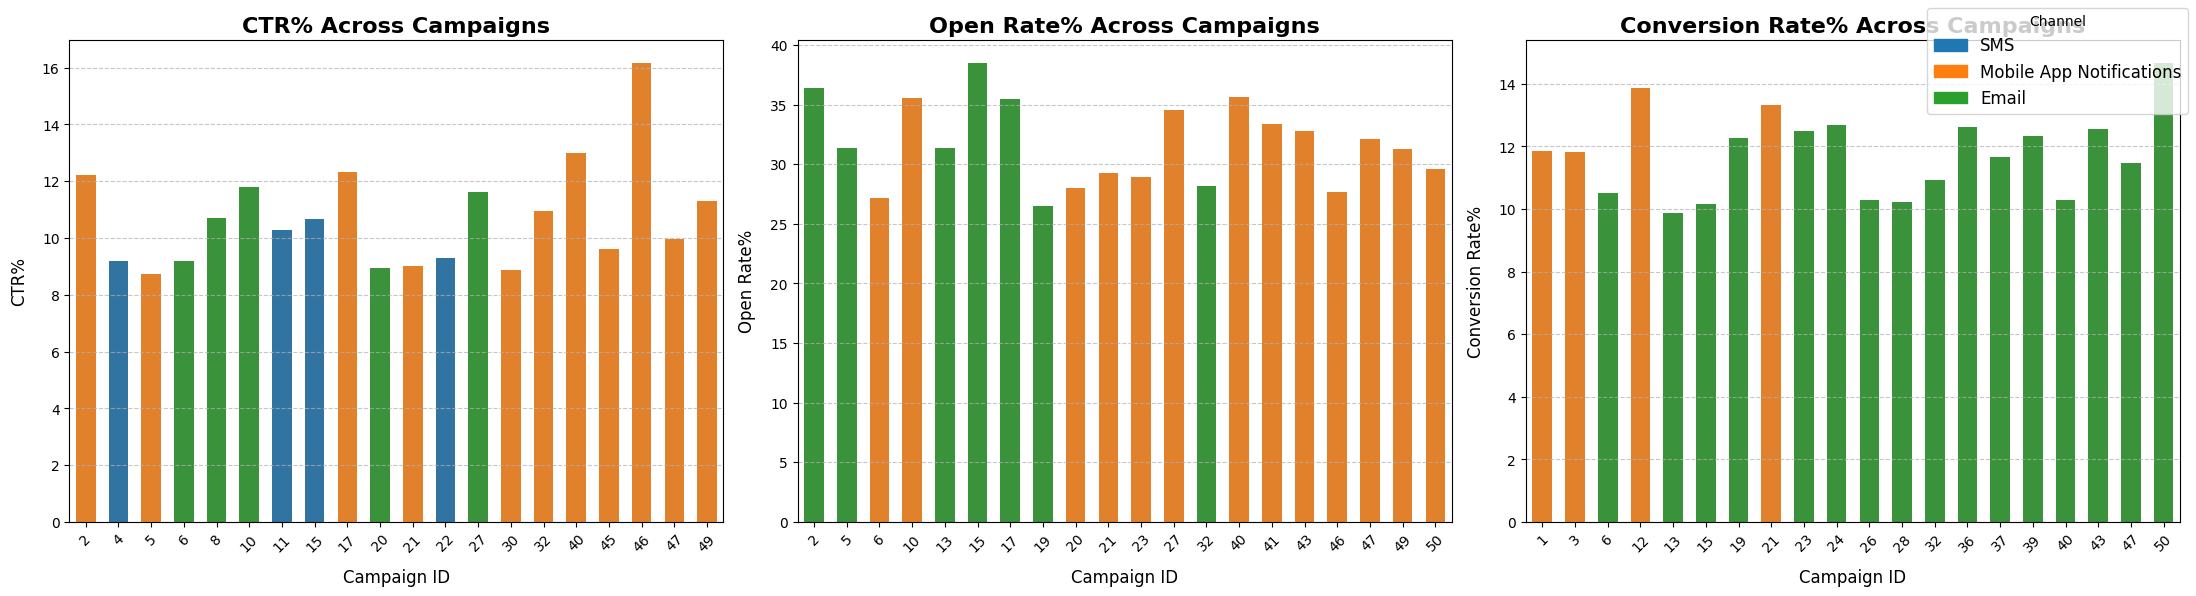

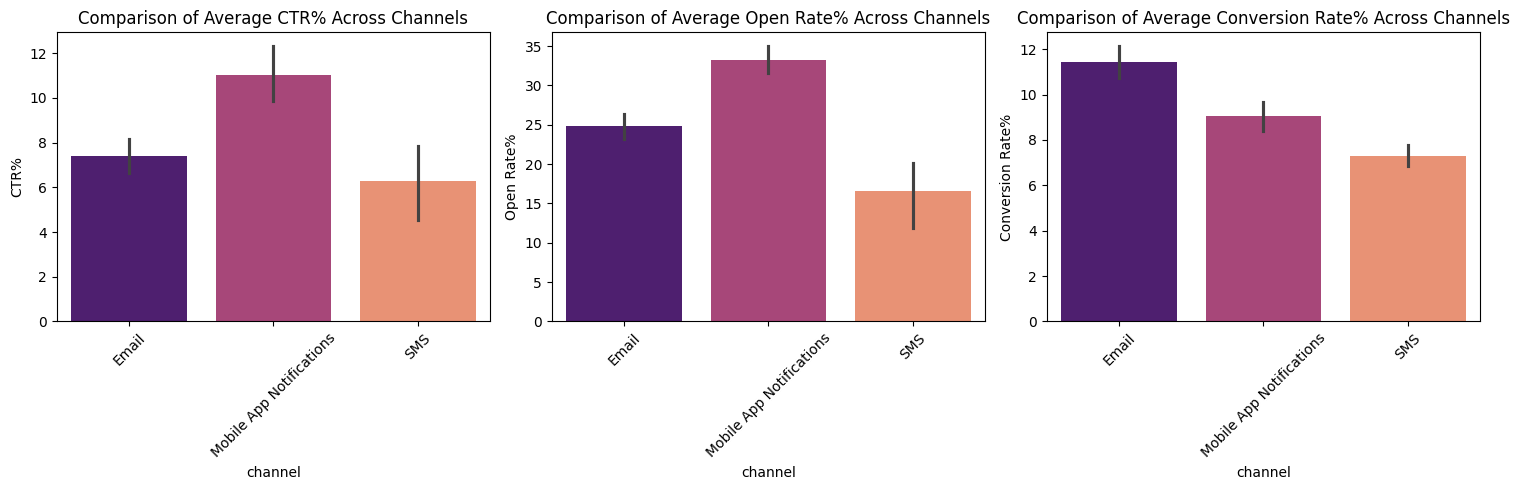

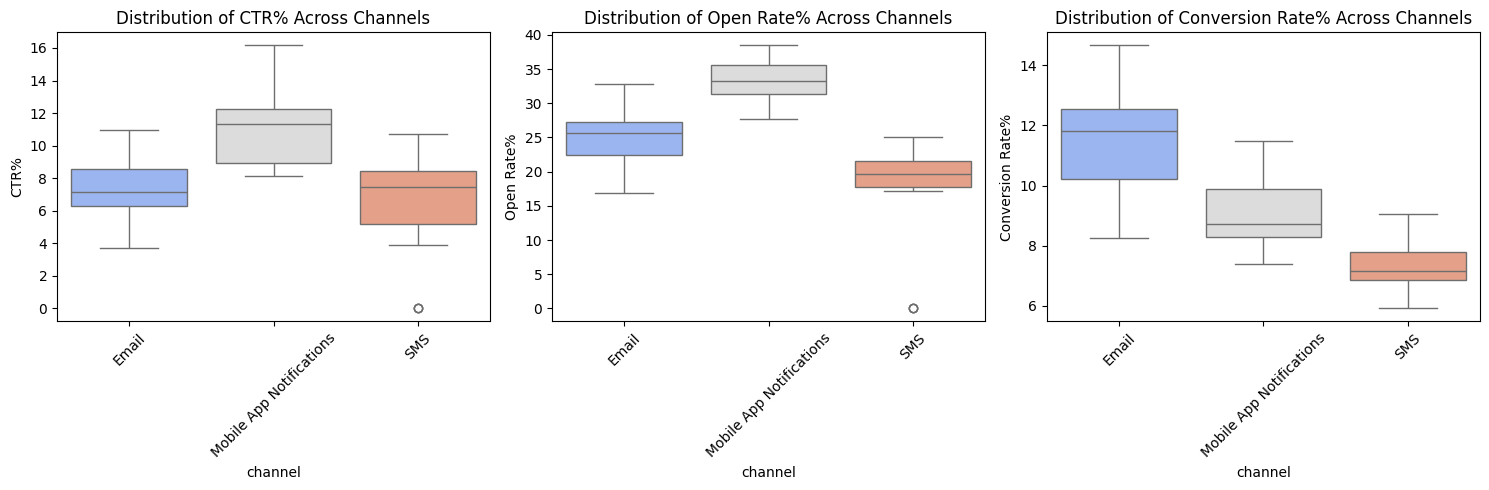

In [157]:
warnings.simplefilter(action='ignore', category=FutureWarning)
campaign_metrics['channel'].value_counts().plot(kind='bar', color='skyblue')
# Compute correlation matrix
campaign_metrics = pd.get_dummies(campaign_metrics, columns=['channel'], drop_first= True)
# Identify the most used channel per campaign
campaign_metrics['channel'] = campaign_metrics[['channel_SMS', 'channel_Mobile App Notifications', 'channel_Email']].idxmax(axis=1)
campaign_metrics['channel'] = campaign_metrics['channel'].str.replace('channel_', '')

# Define color mapping for each channel
channel_colors = {
    "SMS": "#1f77b4",  # Blue
    "Mobile App Notifications": "#ff7f0e",  # Orange
    "Email": "#2ca02c"  # Green
}

# Replace infinite values with NaN and drop NaN rows *before* sorting
campaign_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
campaign_metrics.dropna(subset=['CTR%', 'Open Rate%', 'Conversion Rate%'], how='all', inplace=True)

# Define figure size
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=False)

# Metrics and titles
metrics = ['CTR%', 'Open Rate%', 'Conversion Rate%']
titles = ['CTR% Across Campaigns', 'Open Rate% Across Campaigns', 'Conversion Rate% Across Campaigns']

# Track valid plots
valid_axes = []

# Loop through each metric and create sorted bar plots
for i, metric in enumerate(metrics):
    # Filter out NaN values before sorting
    metric_data = campaign_metrics.dropna(subset=[metric])
    
    if metric_data.empty:  # Skip if no valid data
        axes[i].set_visible(False)
        continue

    valid_axes.append(axes[i])  # Track valid axes
    
    # Sort in ascending order and pick top 20 campaigns
    sorted_campaigns = metric_data.sort_values(by=metric, ascending=True).tail(20)
    
    # Map colors based on the channel type
    colors = sorted_campaigns['channel'].map(channel_colors)
    
    sns.barplot(
        x=sorted_campaigns['campaign_id'], 
        y=sorted_campaigns[metric], 
        ax=axes[i], 
        palette=colors.tolist(),  # Assign colors dynamically
        width=0.6
    )
    
    axes[i].set_title(titles[i], fontsize=16, fontweight='bold')
    axes[i].set_xlabel('Campaign ID', fontsize=12, labelpad=10)
    axes[i].set_ylabel(metric, fontsize=12, labelpad=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Remove unused axes
if len(valid_axes) < len(axes):
    for i in range(len(valid_axes), len(axes)):
        fig.delaxes(axes[i])

# Add a legend for channel colors
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in channel_colors.values()]
labels = list(channel_colors.keys())
fig.legend(handles, labels, title="Channel", loc='upper right', fontsize=12)

# Adjust layout and display plot
plt.tight_layout()
plt.show()


engagement_metrics = ['CTR%', 'Open Rate%', 'Conversion Rate%']

### 🎯 2. Compare Engagement Between Channels (Using One-Hot Encoded Data)
# Compute average engagement per channel
#channel_metrics = campaign_metrics.copy()
plt.figure(figsize=(15, 5))
for i, metric in enumerate(engagement_metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(data=campaign_metrics, x="channel", y=metric, palette="magma")
    plt.xticks(rotation=45)
    plt.title(f"Comparison of Average {metric} Across Channels")

plt.tight_layout()
plt.show()

# Box plot for distribution of engagement across channels
plt.figure(figsize=(15, 5))
for i, metric in enumerate(engagement_metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=campaign_metrics, x="channel", y=metric, palette="coolwarm")
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {metric} Across Channels")

plt.tight_layout()
plt.show()



/var/folders/7n/n7d599bd2v9fcjcymqlnq9_00000gn/T/ipykernel_93582/3319787592.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_daywise_metrics = main_df.groupby("engagement_day").apply(weighted_metrics)


<Figure size 1200x600 with 0 Axes>

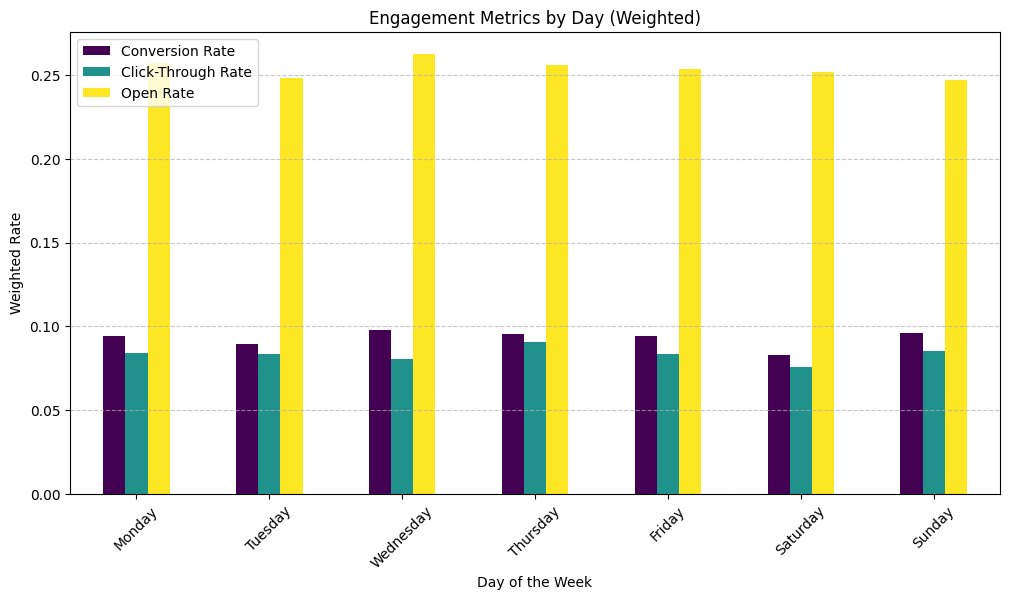

In [158]:
# Define function to calculate weighted metrics
def weighted_metrics(df):
    total_delivered = df["delivered"].sum()
    if total_delivered == 0:  # Avoid division by zero
        return pd.Series({"conversion_rate": 0, "click_through_rate": 0, "open_rate": 0})
    
    return pd.Series({
        "conversion_rate": (df["conversion_status"] * df["delivered"]).sum() / total_delivered,
        "click_through_rate": (df["clicked"] * df["delivered"]).sum() / total_delivered,
        "open_rate": (df["opened"] * df["delivered"]).sum() / total_delivered,
    })

# Ensure zero-division handling by replacing NaN with 0
main_df["open_rate"] = (main_df["opened"] / main_df["delivered"]).fillna(0)
main_df["click_through_rate"] = (main_df["clicked"] / main_df["delivered"]).fillna(0)
main_df["conversion_rate"] = (main_df["clicked"] / main_df["opened"]).fillna(0)

# Group by engagement day and hour
weighted_daywise_metrics = main_df.groupby("engagement_day").apply(weighted_metrics)

# Define day labels
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weighted_daywise_metrics.index = day_labels  # Replace numeric values with actual day names

# Plot Engagement Metrics by Day
plt.figure(figsize=(12, 6))
weighted_daywise_metrics.plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Engagement Metrics by Day (Weighted)")
plt.ylabel("Weighted Rate")
plt.xlabel("Day of the Week")
plt.legend(["Conversion Rate", "Click-Through Rate", "Open Rate"])
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



/var/folders/7n/n7d599bd2v9fcjcymqlnq9_00000gn/T/ipykernel_93582/2764112662.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_day_channel_metrics = main_df.groupby(["engagement_day", "channel"]).apply(weighted_metrics).reset_index()


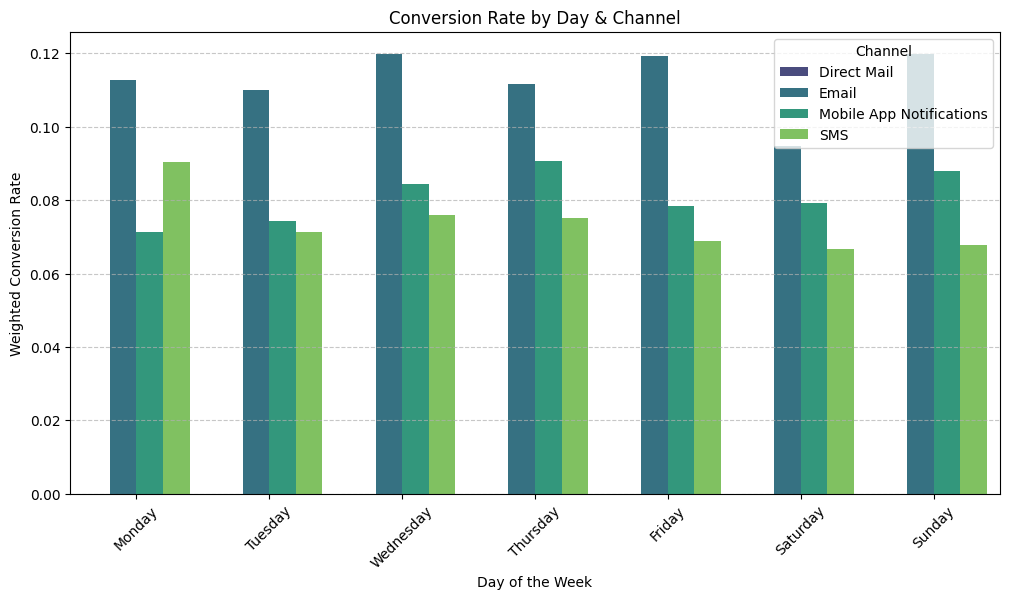

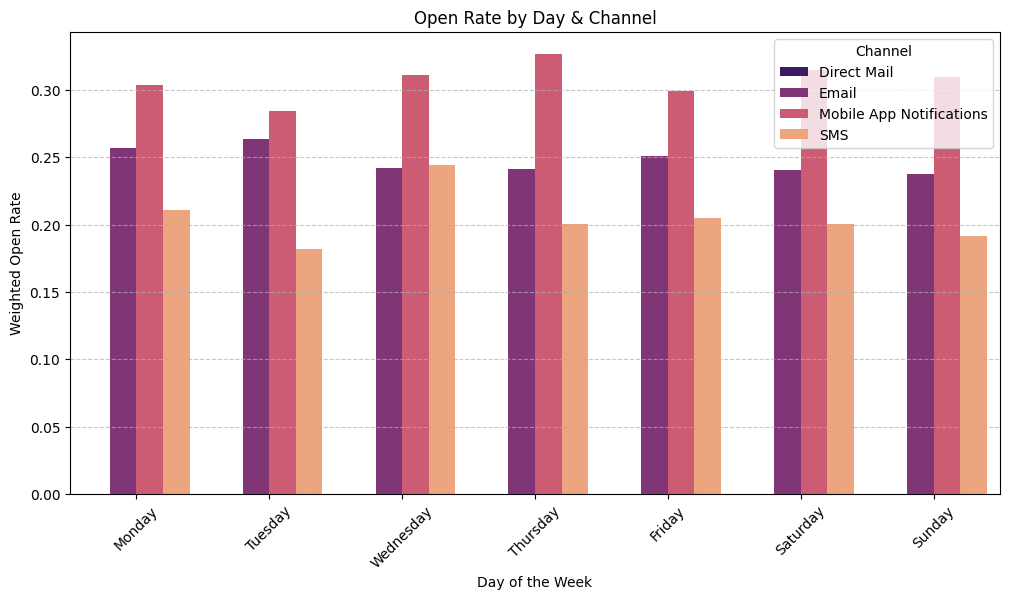

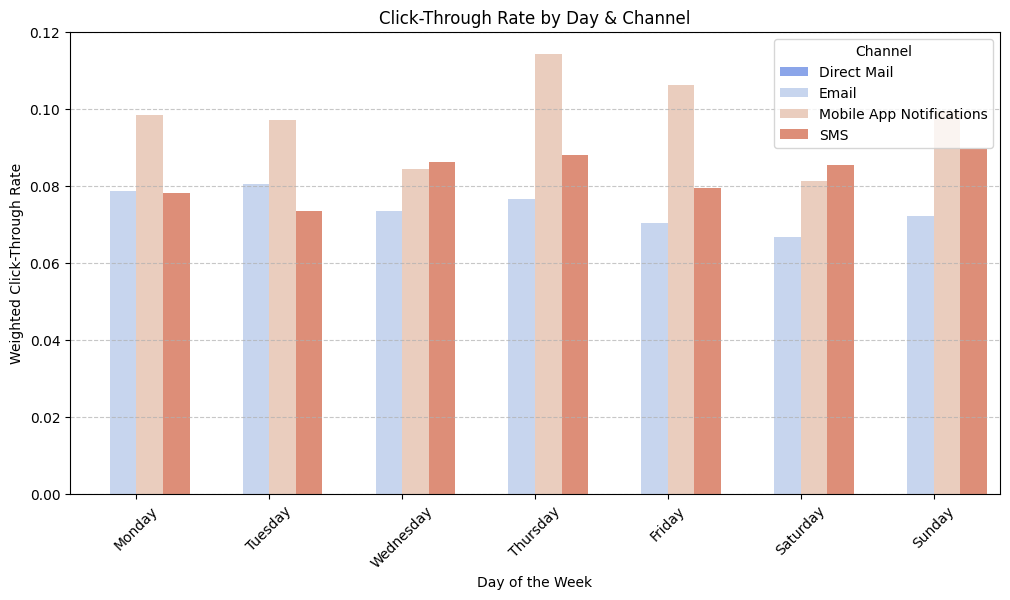

In [159]:
# Function to calculate weighted metrics
def weighted_metrics(df):
    total_delivered = df["delivered"].sum()
    if total_delivered == 0:  # Avoid division by zero
        return pd.Series({"conversion_rate": 0, "click_through_rate": 0, "open_rate": 0})
    
    return pd.Series({
        "conversion_rate": (df["conversion_status"] * df["delivered"]).sum() / total_delivered,
        "click_through_rate": (df["clicked"] * df["delivered"]).sum() / total_delivered,
        "open_rate": (df["opened"] * df["delivered"]).sum() / total_delivered,
    })

# Group by engagement day AND channel
weighted_day_channel_metrics = main_df.groupby(["engagement_day", "channel"]).apply(weighted_metrics).reset_index()

# Replace numeric day values with actual day names
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weighted_day_channel_metrics["engagement_day"] = weighted_day_channel_metrics["engagement_day"].map(lambda x: day_labels[x])

# Plot Engagement Metrics by Day & Channel
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_day_channel_metrics, x="engagement_day", y="conversion_rate", hue="channel", palette="viridis")
plt.title("Conversion Rate by Day & Channel")
plt.ylabel("Weighted Conversion Rate")
plt.xlabel("Day of the Week")
plt.legend(title="Channel")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Open Rate by Day & Channel
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_day_channel_metrics, x="engagement_day", y="open_rate", hue="channel", palette="magma")
plt.title("Open Rate by Day & Channel")
plt.ylabel("Weighted Open Rate")
plt.xlabel("Day of the Week")
plt.legend(title="Channel")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Click-Through Rate by Day & Channel
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_day_channel_metrics, x="engagement_day", y="click_through_rate", hue="channel", palette="coolwarm")
plt.title("Click-Through Rate by Day & Channel")
plt.ylabel("Weighted Click-Through Rate")
plt.xlabel("Day of the Week")
plt.legend(title="Channel")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/7n/n7d599bd2v9fcjcymqlnq9_00000gn/T/ipykernel_93582/4051030723.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_day_product_metrics = main_df.groupby(["engagement_day", "recommended_product_name"]).apply(weighted_metrics).reset_index()


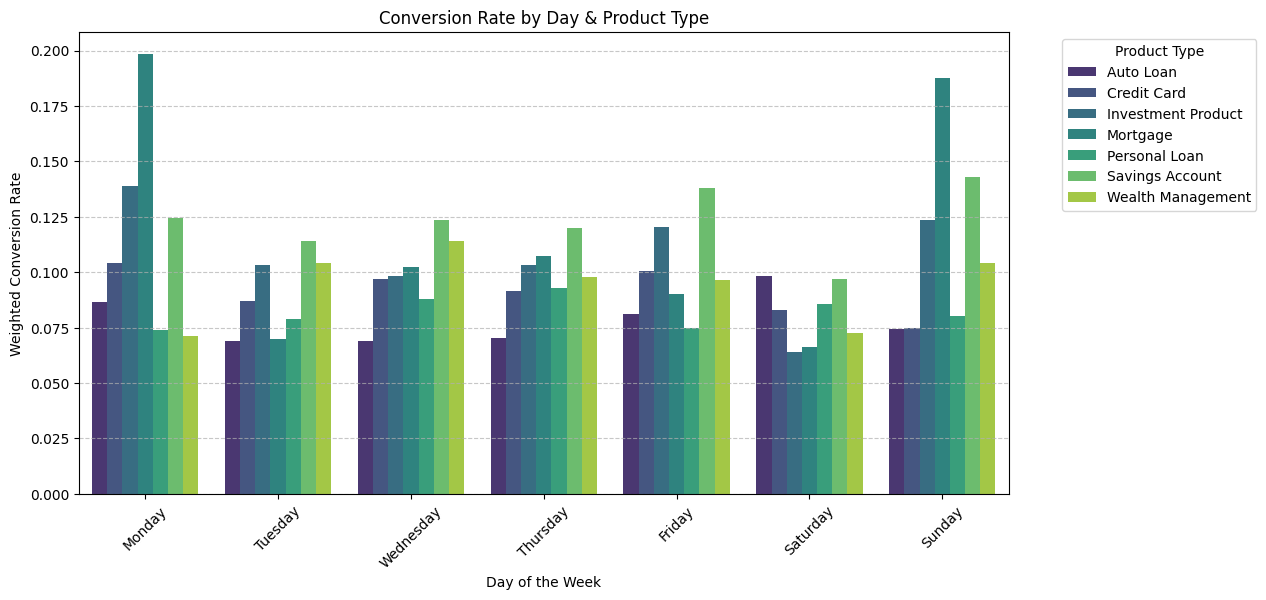

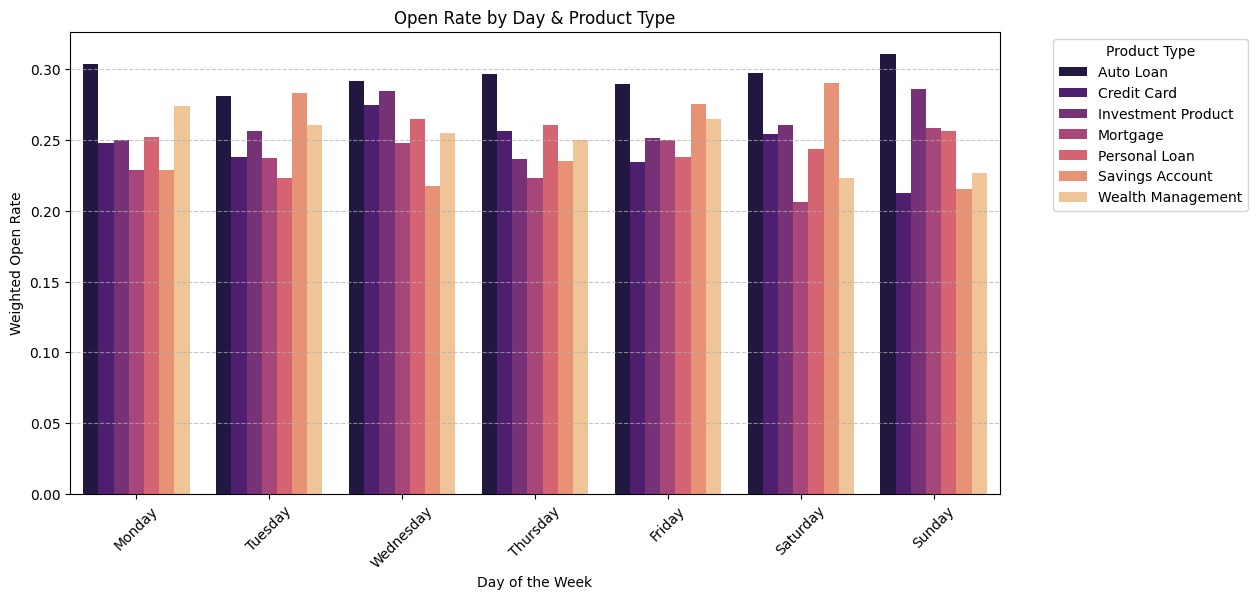

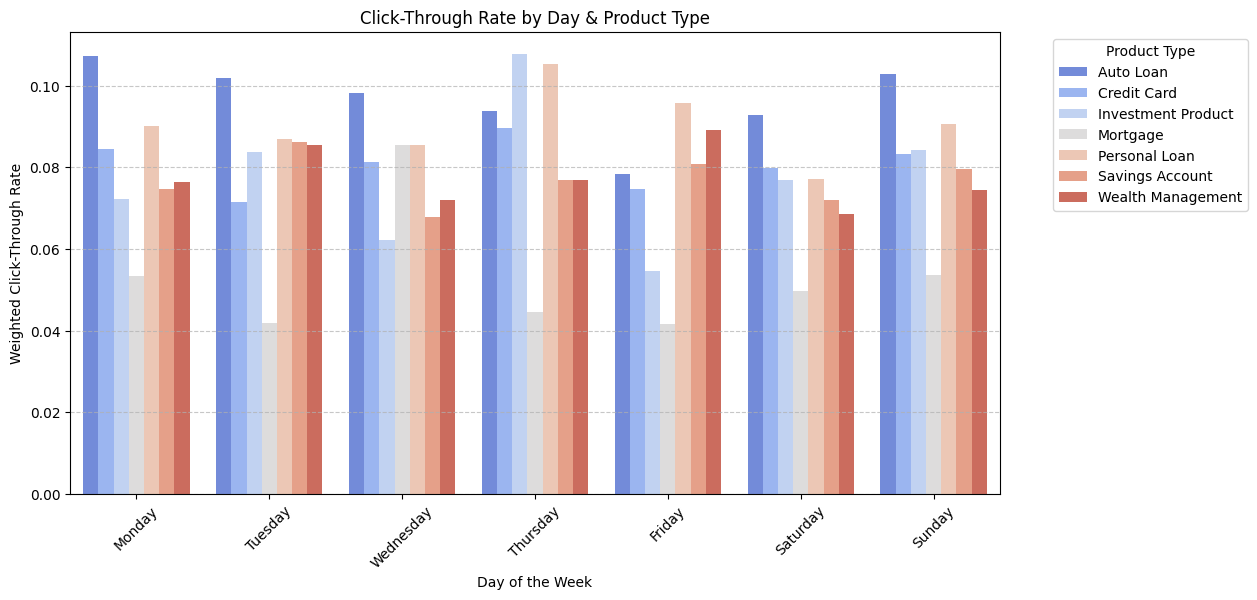

In [160]:
# Group by engagement day AND product type
weighted_day_product_metrics = main_df.groupby(["engagement_day", "recommended_product_name"]).apply(weighted_metrics).reset_index()

# Replace numeric day values with actual day names
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weighted_day_product_metrics["engagement_day"] = weighted_day_product_metrics["engagement_day"].map(lambda x: day_labels[x])

# Plot Conversion Rate by Day & Product
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_day_product_metrics, x="engagement_day", y="conversion_rate", hue="recommended_product_name", palette="viridis")
plt.title("Conversion Rate by Day & Product Type")
plt.ylabel("Weighted Conversion Rate")
plt.xlabel("Day of the Week")
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Open Rate by Day & Product
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_day_product_metrics, x="engagement_day", y="open_rate", hue="recommended_product_name", palette="magma")
plt.title("Open Rate by Day & Product Type")
plt.ylabel("Weighted Open Rate")
plt.xlabel("Day of the Week")
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Click-Through Rate by Day & Product
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_day_product_metrics, x="engagement_day", y="click_through_rate", hue="recommended_product_name", palette="coolwarm")
plt.title("Click-Through Rate by Day & Product Type")
plt.ylabel("Weighted Click-Through Rate")
plt.xlabel("Day of the Week")
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


/var/folders/7n/n7d599bd2v9fcjcymqlnq9_00000gn/T/ipykernel_93582/1563344137.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_product_metrics = main_df.groupby("recommended_product_name").apply(weighted_metrics).reset_index()


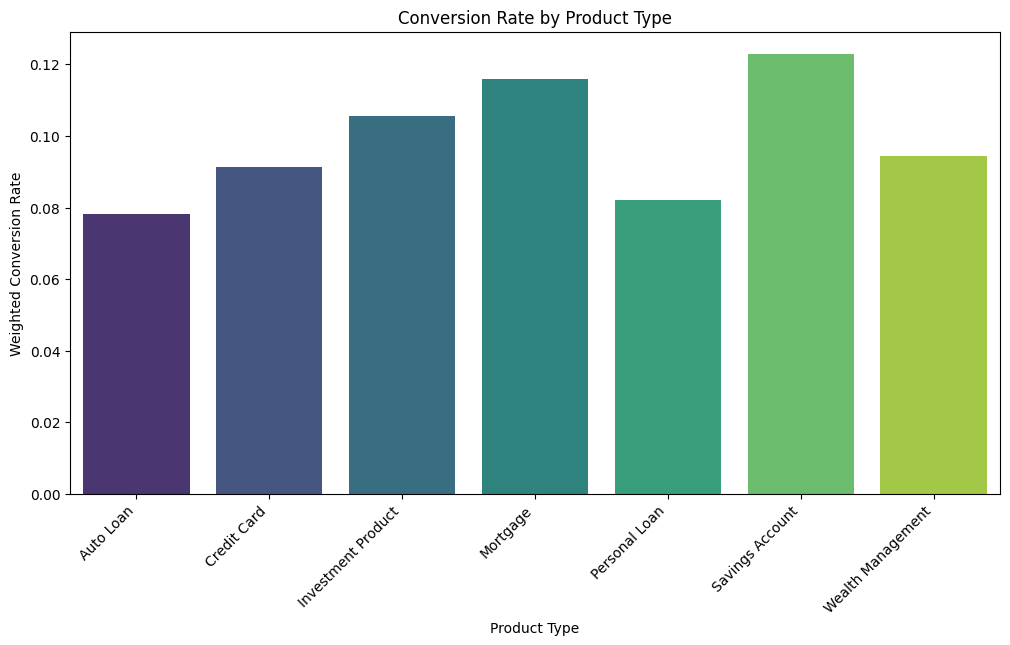

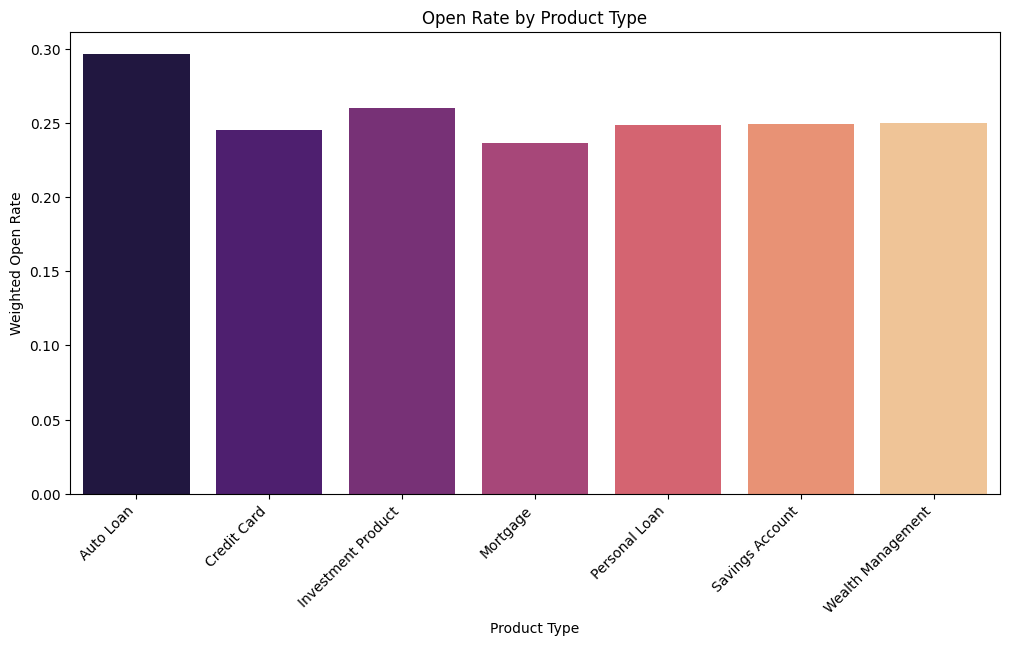

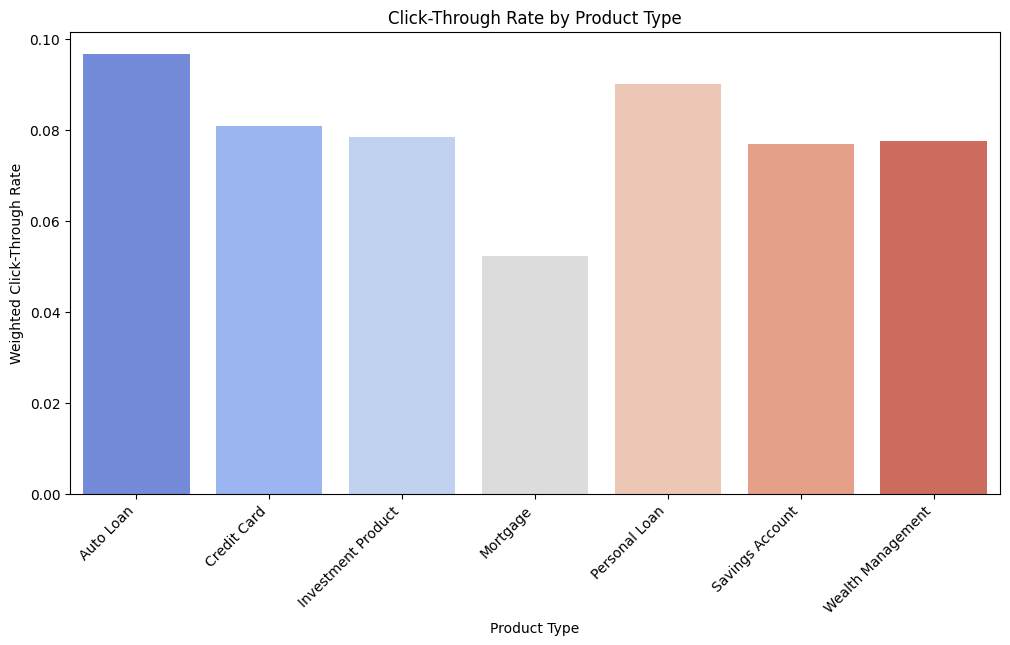

In [177]:
# Group by product type and compute weighted engagement metrics
weighted_product_metrics = main_df.groupby("recommended_product_name").apply(weighted_metrics).reset_index()

# Plot Conversion Rate by Product Type
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_product_metrics, x="recommended_product_name", y="conversion_rate", palette="viridis")
plt.title("Conversion Rate by Product Type")
plt.ylabel("Weighted Conversion Rate")
plt.xlabel("Product Type")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="", alpha=0.7)
plt.show()

# Plot Open Rate by Product Type
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_product_metrics, x="recommended_product_name", y="open_rate", palette="magma")
plt.title("Open Rate by Product Type")
plt.ylabel("Weighted Open Rate")
plt.xlabel("Product Type")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="", alpha=0.7)
plt.show()

# Plot Click-Through Rate by Product Type
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_product_metrics, x="recommended_product_name", y="click_through_rate", palette="coolwarm")
plt.title("Click-Through Rate by Product Type")
plt.ylabel("Weighted Click-Through Rate")
plt.xlabel("Product Type")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="", alpha=0.7)
plt.show()


In [162]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Compute Cramér’s V for "Channel" vs "Clicked"
contingency_table_cramer = pd.crosstab(main_df["channel"], main_df["clicked"])
cramers_v_value = cramers_v(contingency_table_cramer)
#print(contingency_table_cramer)
print("Cramér’s V for Channel and Clicked:", cramers_v_value)

# Compute Cramér’s V for "Channel" vs "Opened"
contingency_table_cramer_2 = pd.crosstab(main_df["channel"], main_df["opened"])
cramers_v_value_2 = cramers_v(contingency_table_cramer_2)
#print(contingency_table_cramer_2)
print("Cramér’s V for Channel and Opened:", cramers_v_value_2)

# Compute Cramér’s V for "Channel" vs "Delivered"
contingency_table_cramer_3 = pd.crosstab(main_df["channel"], main_df["delivered"])
cramers_v_value_3 = cramers_v(contingency_table_cramer_3)
#print(contingency_table_cramer_3)
print("Cramér’s V for Channel and Delivered:", cramers_v_value_3)

# Compute Cramér’s V for "Channel" vs "Conversion Status"
contingency_table_cramer_4 = pd.crosstab(main_df["channel"], main_df["conversion_status"])
cramers_v_value_4 = cramers_v(contingency_table_cramer_4)
#print(contingency_table_cramer_4)
print("Cramér’s V for Channel and Conversion Status:", cramers_v_value_4)




Cramér’s V for Channel and Clicked: 0.08372924734238613
Cramér’s V for Channel and Opened: 0.16841533014530646
Cramér’s V for Channel and Delivered: 0.8021685597566524
Cramér’s V for Channel and Conversion Status: 0.06152379668718183


In [163]:
# Compute Cramer's V for "Recommended Product Name" vs "Clicked"
contingency_table_product_clicked = pd.crosstab(main_df["recommended_product_name"], main_df["clicked"])
cramers_v_product_clicked = cramers_v(contingency_table_product_clicked)
#print(contingency_table_product_clicked)
print("Cramér’s V for Product and Clicked:", cramers_v_product_clicked)

# Compute Cramer's V for "Recommended Product Name" vs "Opened"
contingency_table_product_opened = pd.crosstab(main_df["recommended_product_name"], main_df["opened"])
cramers_v_product_opened = cramers_v(contingency_table_product_opened)
#print(contingency_table_product_opened)
print("Cramér’s V for Product and Opened:", cramers_v_product_opened)

# Compute Cramer's V for "Recommended Product Name" vs "Delivered"
contingency_table_product_delivered = pd.crosstab(main_df["recommended_product_name"], main_df["delivered"])
cramers_v_product_delivered = cramers_v(contingency_table_product_delivered)
#print(contingency_table_product_delivered)
print("Cramér’s V for Product and Delivered:", cramers_v_product_delivered)

# Compute Cramer's V for "Recommended Product Name" vs "Conversion Status"
contingency_table_product_conversion = pd.crosstab(main_df["recommended_product_name"], main_df["conversion_status"])
cramers_v_product_conversion = cramers_v(contingency_table_product_conversion)
#print(contingency_table_product_conversion)
print("Cramér’s V for Product and Conversion Status:", cramers_v_product_conversion)




Cramér’s V for Product and Clicked: 0.06479229162765512
Cramér’s V for Product and Opened: 0.09495743739152512
Cramér’s V for Product and Delivered: 0.440530455901148
Cramér’s V for Product and Conversion Status: 0.037537882247465695


In [164]:
# Compute Kramer's V for "Day" vs "Clicked"
contingency_table_day_clicked = pd.crosstab(main_df["engagement_day"], main_df["clicked"])
cramers_v_day_clicked = cramers_v(contingency_table_day_clicked)
#print(contingency_table_day_clicked)
print("Cramér’s V for Day and Clicked:", cramers_v_day_clicked)

# Compute Kramer's V for "Day" vs "Opened"
contingency_table_day_opened = pd.crosstab(main_df["engagement_day"], main_df["opened"])
cramers_v_day_opened = cramers_v(contingency_table_day_opened)
#print(contingency_table_day_opened)
print("Cramér’s V for Day and Opened:", cramers_v_day_opened)

# Compute Kramer's V for "Day" vs "Delivered"
contingency_table_day_delivered = pd.crosstab(main_df["engagement_day"], main_df["delivered"])
cramers_v_day_delivered = cramers_v(contingency_table_day_delivered)
#print(contingency_table_day_delivered)
print("Cramér’s V for Day and Delivered:", cramers_v_day_delivered)

# Compute Kramer's V for "Day" vs "Conversion Status"
contingency_table_day_conversion = pd.crosstab(main_df["engagement_day"], main_df["conversion_status"])
cramers_v_day_conversion = cramers_v(contingency_table_day_conversion)
#print(contingency_table_day_conversion)
print("Cramér’s V for Day and Conversion Status:", cramers_v_day_conversion)


Cramér’s V for Day and Clicked: 0.015346943796013975
Cramér’s V for Day and Opened: 0.00998730226719628
Cramér’s V for Day and Delivered: 0.016931708529445144
Cramér’s V for Day and Conversion Status: 0.01448736730478303


In [165]:
# Compute Kramer's V for Cluster and Clicked
contingency_table_cluster_clicked = pd.crosstab(main_df["cluster"], main_df["clicked"])
cramers_v_cluster_clicked = cramers_v(contingency_table_cluster_clicked)
#print(contingency_table_cluster_clicked)
print("Cramér’s V for Cluster and Clicked:", cramers_v_cluster_clicked)

# Compute Kramer's V for Cluster and Opened
contingency_table_cluster_opened = pd.crosstab(main_df["cluster"], main_df["opened"])
cramers_v_cluster_opened = cramers_v(contingency_table_cluster_opened)
#print(contingency_table_cluster_opened)
print("Cramér’s V for Cluster and Opened:", cramers_v_cluster_opened)

# Compute Kramer's V for Cluster and Delivered
contingency_table_cluster_delivered = pd.crosstab(main_df["cluster"], main_df["delivered"])
cramers_v_cluster_delivered = cramers_v(contingency_table_cluster_delivered)
#print(contingency_table_cluster_delivered)
print("Cramér’s V for Cluster and Delivered:", cramers_v_cluster_delivered)

# Compute Kramer's V for Cluster and Conversion Status
contingency_table_cluster_conversion = pd.crosstab(main_df["cluster"], main_df["conversion_status"])
cramers_v_cluster_conversion = cramers_v(contingency_table_cluster_conversion)
#print(contingency_table_cluster_conversion)
print("Cramér’s V for Cluster and Conversion Status:", cramers_v_cluster_conversion)

Cramér’s V for Cluster and Clicked: 0.006511971123945471
Cramér’s V for Cluster and Opened: 0.0053907325873116365
Cramér’s V for Cluster and Delivered: 0.004318129240360008
Cramér’s V for Cluster and Conversion Status: 0.01775492965707612


   cluster  conversion_rate  click_through_rate  open_rate
0        0         0.081708            0.081399   0.246673
1        1         0.100105            0.087277   0.250263
2        2         0.092954            0.082519   0.256072


/var/folders/7n/n7d599bd2v9fcjcymqlnq9_00000gn/T/ipykernel_93582/1031512088.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_cluster_metrics = main_df.groupby("cluster").apply(weighted_metrics).reset_index()


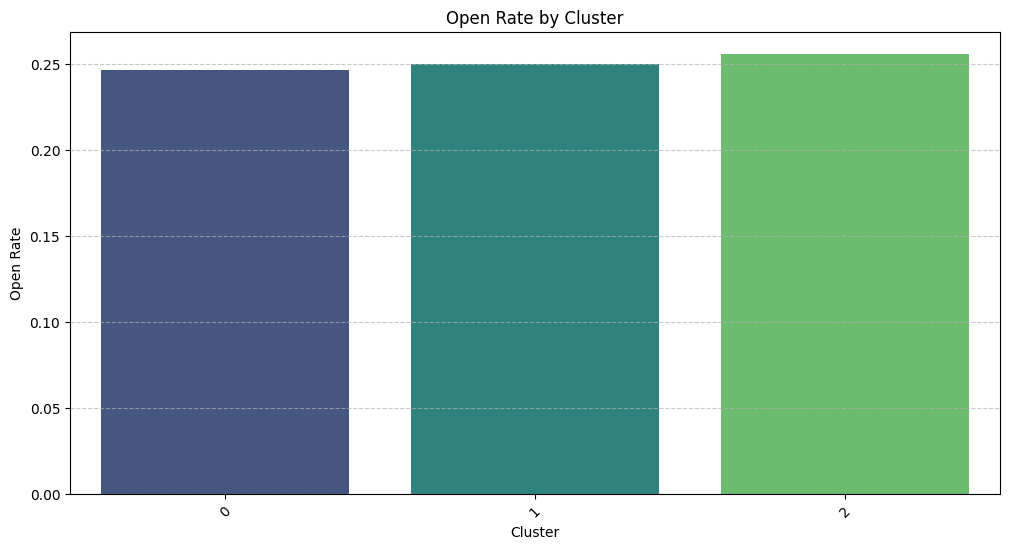

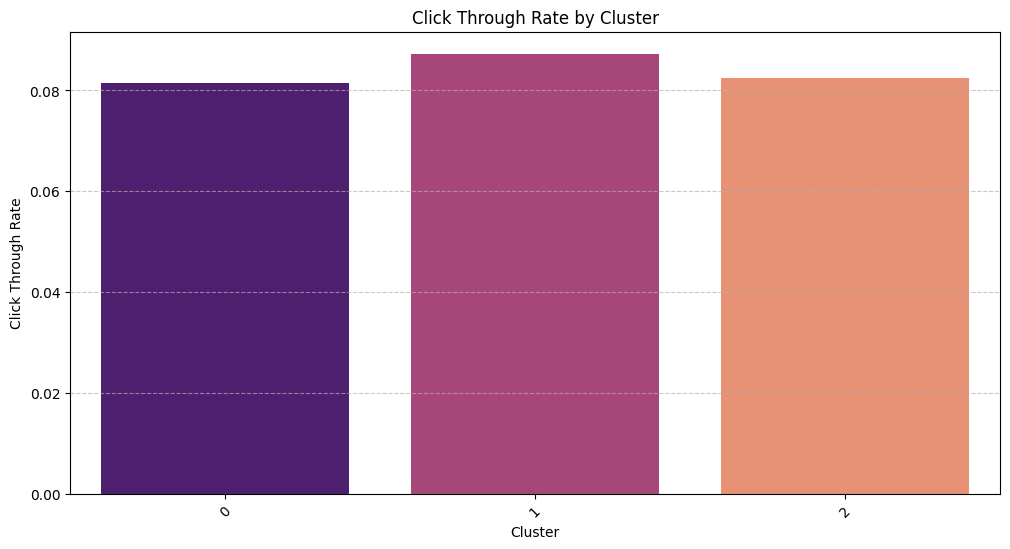

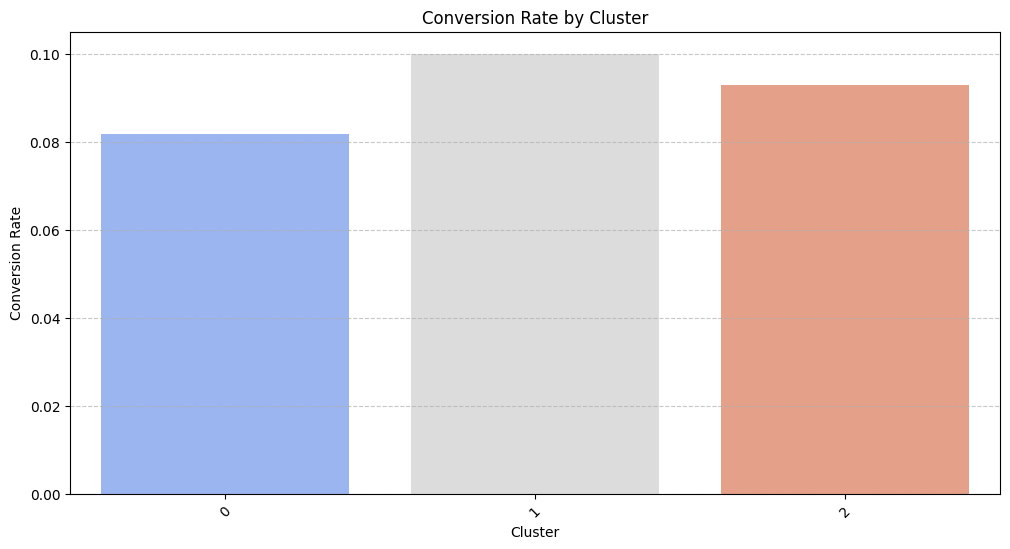

In [166]:
weighted_cluster_metrics = main_df.groupby("cluster").apply(weighted_metrics).reset_index()
print(weighted_cluster_metrics)
# Create a barplot of Cluster and open rate, clcik through rate, conversion rate
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_cluster_metrics, x="cluster", y="open_rate", palette="viridis")
plt.title("Open Rate by Cluster")
plt.ylabel("Open Rate")
plt.xlabel("Cluster")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Barplot of Click Through Rate by Cluster
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_cluster_metrics, x="cluster", y="click_through_rate", palette="magma")
plt.title("Click Through Rate by Cluster")
plt.ylabel("Click Through Rate")
plt.xlabel("Cluster")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Barplot of Conversion Rate by Cluster
plt.figure(figsize=(12, 6))
sns.barplot(data=weighted_cluster_metrics, x="cluster", y="conversion_rate", palette="coolwarm")
plt.title("Conversion Rate by Cluster")
plt.ylabel("Conversion Rate")
plt.xlabel("Cluster")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



/var/folders/7n/n7d599bd2v9fcjcymqlnq9_00000gn/T/ipykernel_93582/1935612329.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_channel_metrics = main_df.groupby(["cluster", "channel"]).apply(weighted_metrics).reset_index()


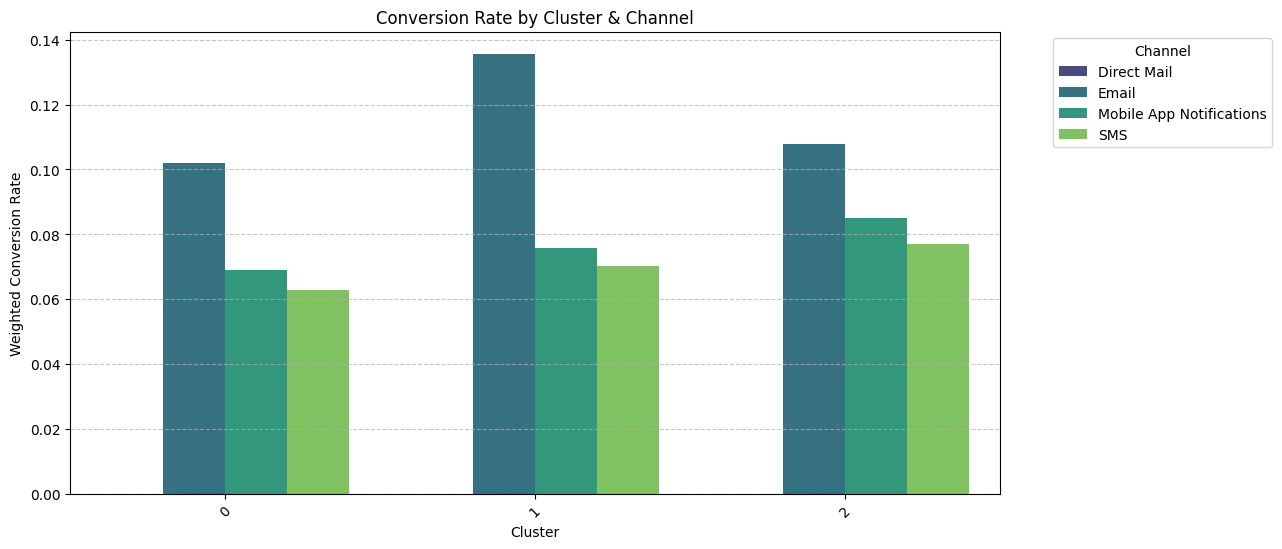

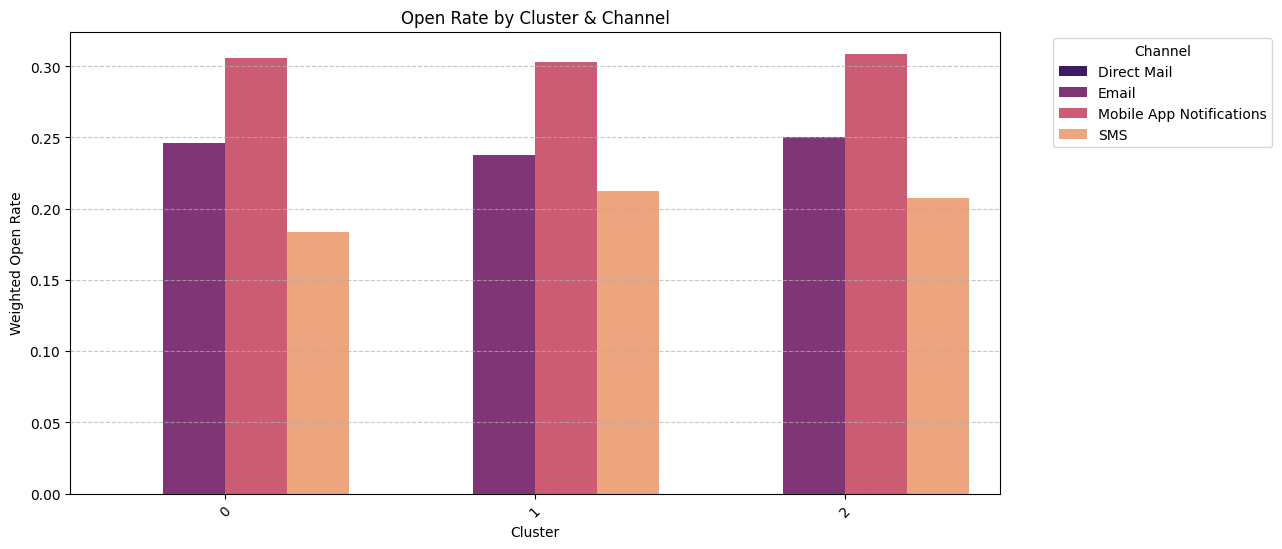

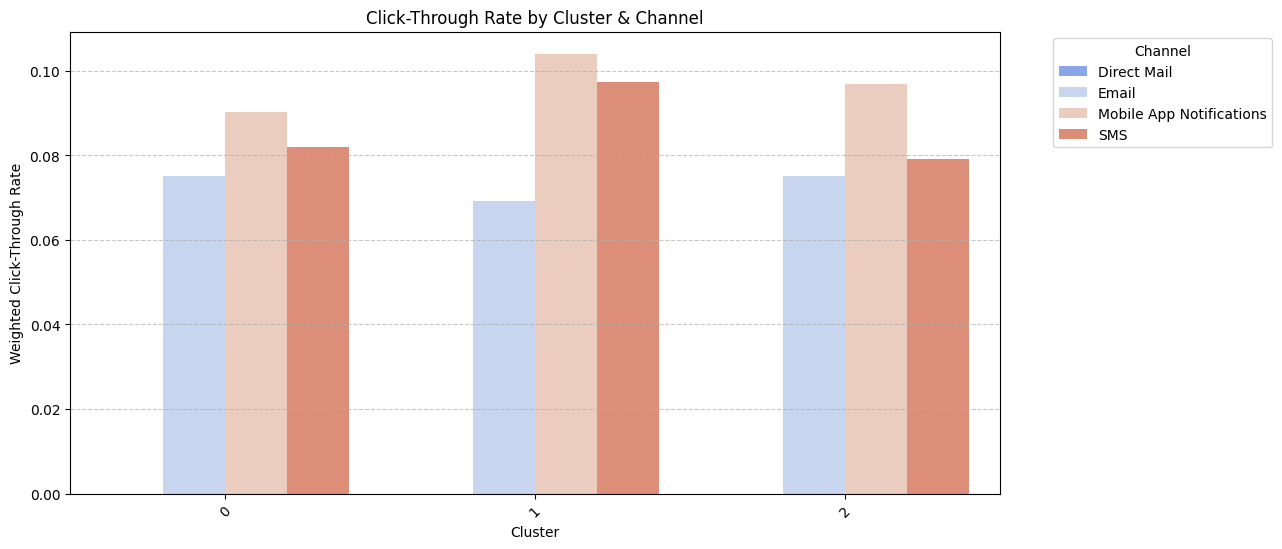

In [167]:
# Compute engagment metrics for each cluster grouped by cluster and channel
cluster_channel_metrics = main_df.groupby(["cluster", "channel"]).apply(weighted_metrics).reset_index()
#print(cluster_channel_metrics)

# Plot Conversion Rate by Cluster & Channel
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_channel_metrics, x="cluster", y="conversion_rate", hue="channel", palette="viridis")
plt.title("Conversion Rate by Cluster & Channel")
plt.ylabel("Weighted Conversion Rate")
plt.xlabel("Cluster")
plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()  

# Plot Open Rate by Cluster & Channel
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_channel_metrics, x="cluster", y="open_rate", hue="channel", palette="magma")
plt.title("Open Rate by Cluster & Channel")
plt.ylabel("Weighted Open Rate")
plt.xlabel("Cluster")
plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Click-Through Rate by Cluster & Channel
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_channel_metrics, x="cluster", y="click_through_rate", hue="channel", palette="coolwarm")
plt.title("Click-Through Rate by Cluster & Channel")
plt.ylabel("Weighted Click-Through Rate")
plt.xlabel("Cluster")
plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



/var/folders/7n/n7d599bd2v9fcjcymqlnq9_00000gn/T/ipykernel_93582/2156207178.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_product_metrics = main_df.groupby(["cluster", "recommended_product_name"]).apply(weighted_metrics).reset_index()


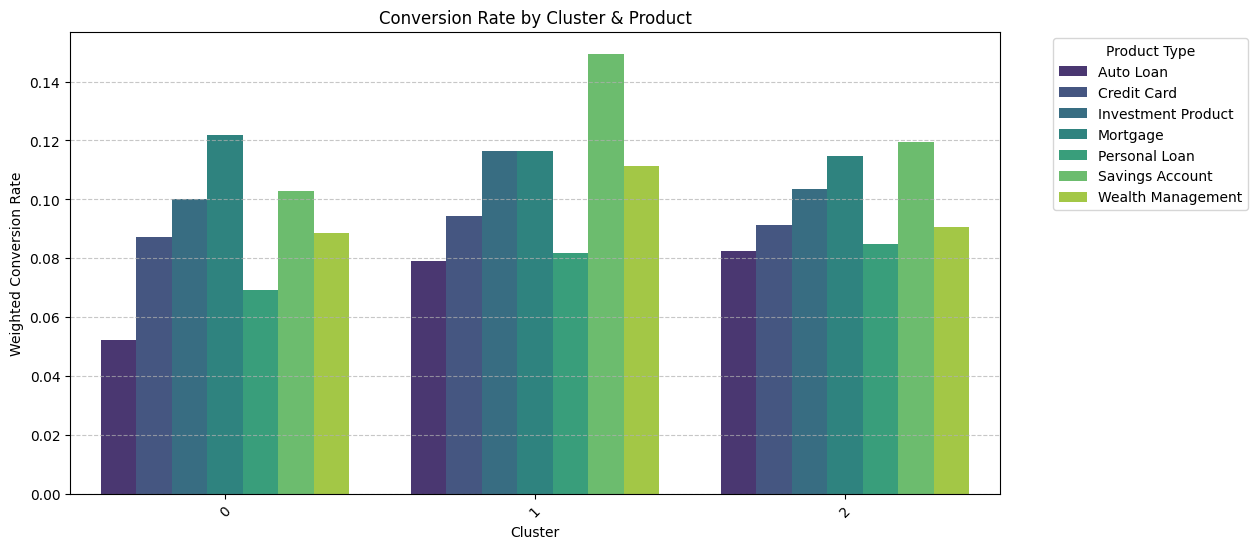

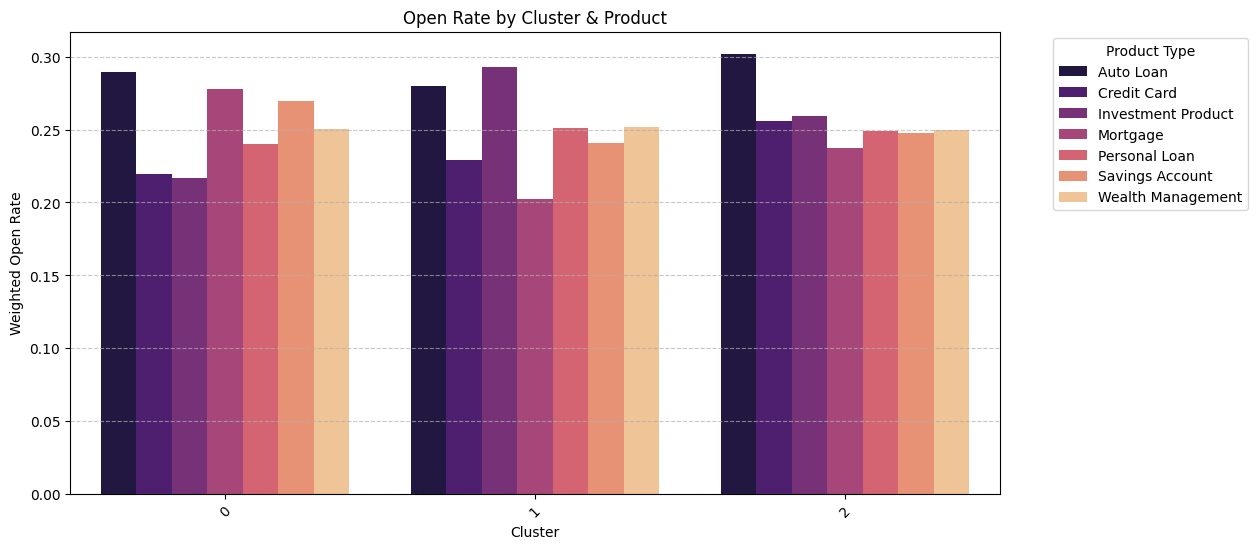

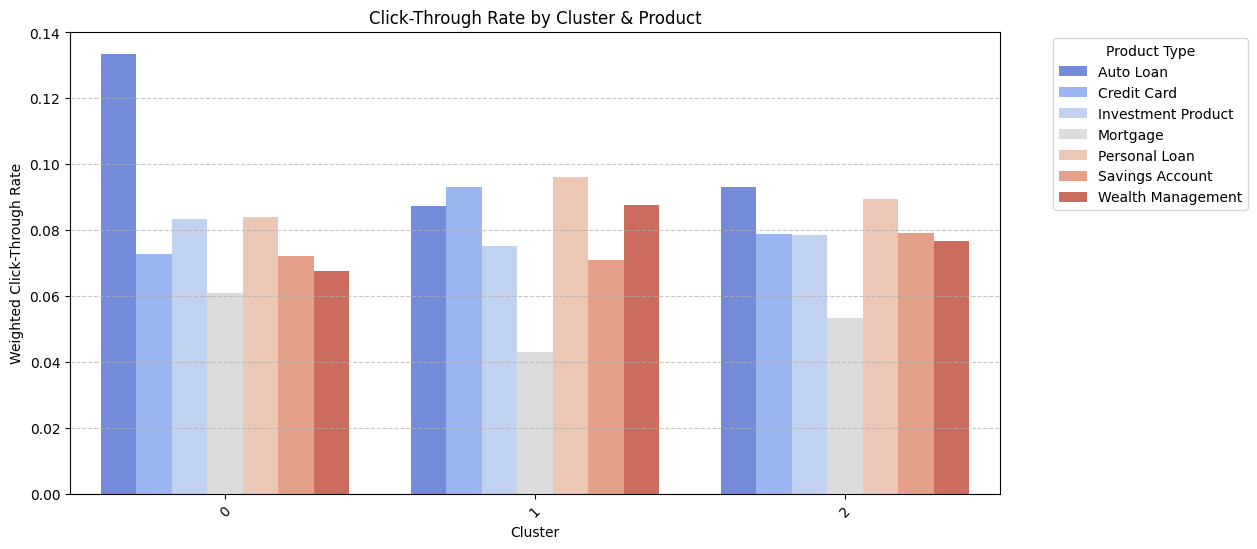

In [168]:
# Compute engagment metrics for each cluster grouped by cluster and product
cluster_product_metrics = main_df.groupby(["cluster", "recommended_product_name"]).apply(weighted_metrics).reset_index()
#print(cluster_product_metrics)

# Plot Conversion Rate by Cluster & Product
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_product_metrics, x="cluster", y="conversion_rate", hue="recommended_product_name", palette="viridis")
plt.title("Conversion Rate by Cluster & Product")
plt.ylabel("Weighted Conversion Rate")
plt.xlabel("Cluster")
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Open Rate by Cluster & Product
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_product_metrics, x="cluster", y="open_rate", hue="recommended_product_name", palette="magma")
plt.title("Open Rate by Cluster & Product")
plt.ylabel("Weighted Open Rate")
plt.xlabel("Cluster")
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Click-Through Rate by Cluster & Product
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_product_metrics, x="cluster", y="click_through_rate", hue="recommended_product_name", palette="coolwarm")
plt.title("Click-Through Rate by Cluster & Product")
plt.ylabel("Weighted Click-Through Rate")
plt.xlabel("Cluster")
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
